In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

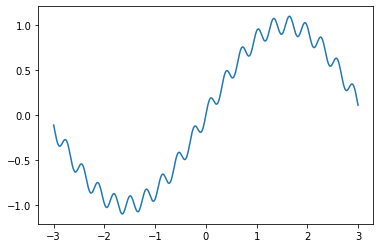

In [3]:
# pytorch only takes 2d x input so we use unsqueeze to insert a dimension of size one
def sum_of_sines(a=1, b=20, w=0.1):
    x = torch.unsqueeze(torch.linspace(-3, 3, 1000), dim=1)
    y = (torch.sin(a*x) + w*torch.sin(b*x))

    # plot
    plt.plot(x.data.numpy(),y.data.numpy())
    return x, y

_, _ = sum_of_sines()

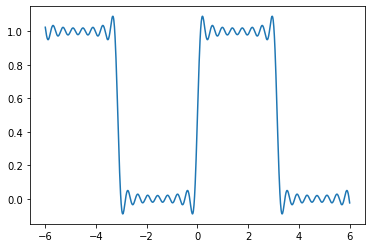

In [4]:
"""
Square wave

A(X) = 0.5 + sum(all the odd N's){ 2*sin(nx)/(n*pi) }

# N_max: the larger the value the steeper the transition from 0 to 1 and the more "square"
"""

def square_wave(N_max=16):
    n_odds = torch.arange(1, N_max, 2)
    xs = torch.unsqueeze(torch.linspace(-6, 6, 1000), dim=1)
    ys = torch.unsqueeze(torch.as_tensor([0.5+sum(np.multiply(2/(n_odds*np.pi), np.sin(n_odds*x))) for x in xs]), dim=1)
    plt.plot(xs, ys)
    
    return xs, ys

_, _ = square_wave()

In [5]:
def relu_k(x, k):
    return torch.clamp(x**k, min=0)

def sine(x, k=None):
    return torch.sin(x)

In [6]:
class ThreeLayerNet(nn.Module):
    def __init__(self, network_width=500):
        super(ThreeLayerNet, self).__init__() 
        self.linear_1 = nn.Linear(1, network_width) 
        self.linear_2 = nn.Linear(network_width, network_width) 
        self.linear_3 = nn.Linear(network_width, 1)
        
        # weight initialization
        scale = 1/np.sqrt(network_width)
        nn.init.normal_(self.linear_1.weight, mean=0.0, std=scale)
        nn.init.normal_(self.linear_1.bias, mean=0.0, std=scale)
        nn.init.normal_(self.linear_2.weight, mean=0.0, std=scale)
        nn.init.normal_(self.linear_2.bias, mean=0.0, std=scale)
        nn.init.normal_(self.linear_3.weight, mean=0.0, std=scale)
        nn.init.normal_(self.linear_3.bias, mean=0.0, std=scale)
        
    def forward(self, x, k, activation_1, activation_2):
        
        act_1 = relu_k if activation_1 == 'relu' else sine
        act_2 = relu_k if activation_2 == 'relu' else sine 
        
        x = act_1(self.linear_1(x), k) 
        x = act_2(self.linear_2(x), k)  
        
        x = self.linear_3(x)
        return x

In [7]:
def train(x, y, k=1, activation_1='relu', activation_2='relu', lr=0.1):
    # init model, optimizer, loss function 
    net = ThreeLayerNet()
    optimizer = torch.optim.SGD(net.parameters(), lr)
    loss_func = torch.nn.MSELoss()
    
    net = net.to(device)
    x = x.to(device)
    y = y.to(device)
    
    for t in (range(2000)):
        prediction = net(x, k, activation_1, activation_2)
        loss = loss_func(prediction, y)

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

        if (t+1) % 2000 == 0:
            # plot and show learning process
            plt.title(f'NTK-regime-{activation_1}-{activation_2}')
            plt.plot(x.cpu().data, y.cpu().data, 'b')
            plt.plot(x.cpu().data, prediction.cpu().data, 'r-', lw=2)
            plt.text(7.0, 0.5, f'iteration {t+1}, Loss={loss.cpu().data}', fontdict={'size': 15, 'color':  'red'})
            plt.pause(0.1)

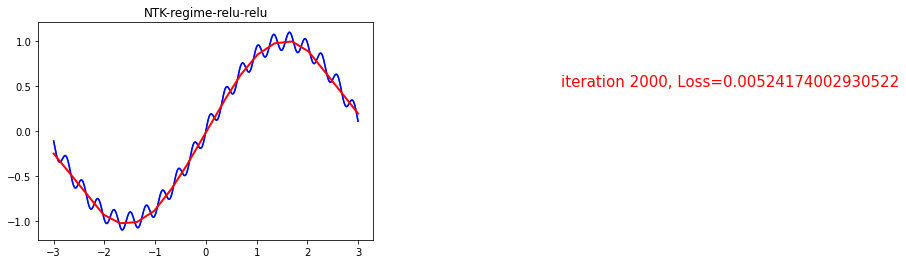

In [8]:
x, y = sum_of_sines()
train(x, y, k=1, activation_1='relu', activation_2='relu', lr=0.1)

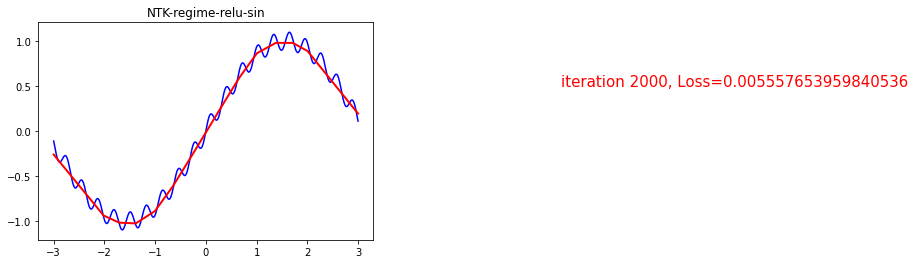

In [9]:
train(x, y, k=1, activation_1='relu', activation_2='sin', lr=0.1)

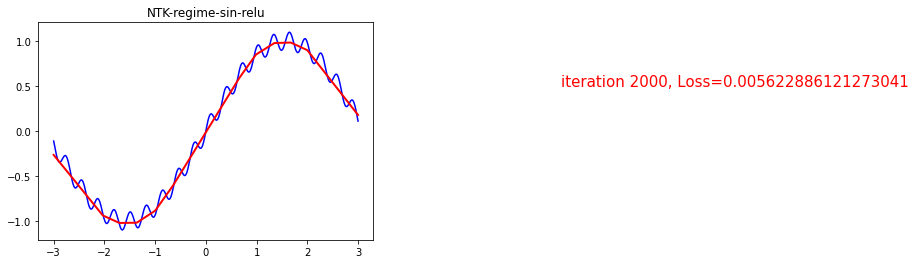

In [11]:
train(x, y, k=1, activation_1='sin', activation_2='relu', lr=0.1)

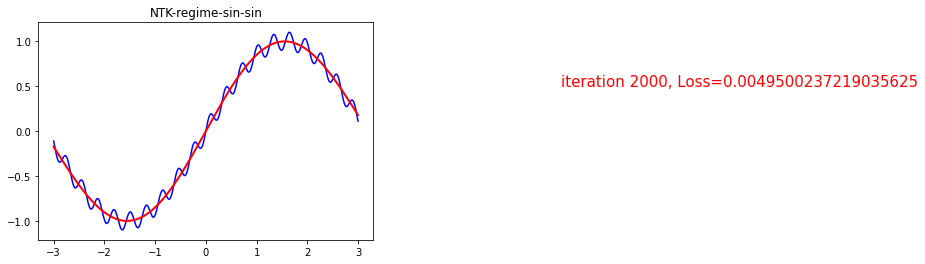

In [12]:
train(x, y, k=1, activation_1='sin', activation_2='sin', lr=0.1)

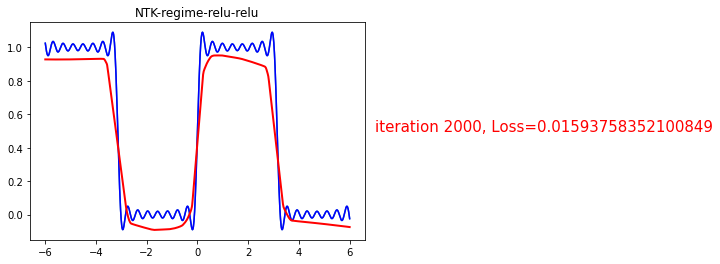

In [13]:
xs, ys = square_wave()
train(xs, ys, k=1, activation_1='relu', activation_2='relu', lr=0.1)

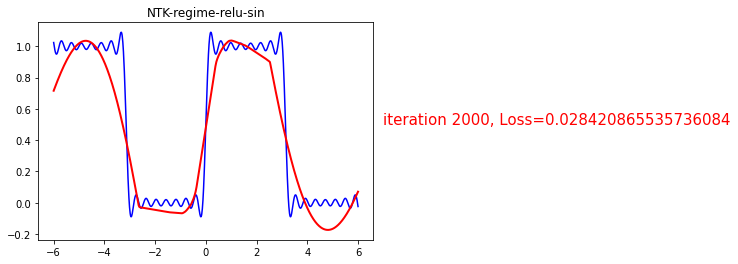

In [14]:
train(xs, ys, k=1, activation_1='relu', activation_2='sin', lr=0.1)

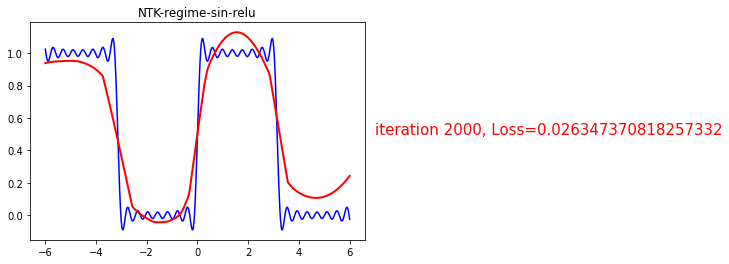

In [15]:
train(xs, ys, k=1, activation_1='sin', activation_2='relu', lr=0.1)

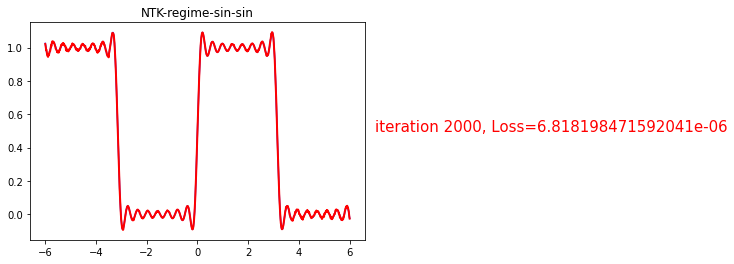

In [16]:
train(xs, ys, k=1, activation_1='sin', activation_2='sin', lr=0.1)

In [17]:
# mean-field regime